In [1]:
# --------------------------------------------------------
# Written by Yufei Ye and modified by Sheng-Yu Wang (https://github.com/JudyYe)
# Convert from MATLAB code https://inst.eecs.berkeley.edu/~cs194-26/fa18/hw/proj3/gradient_starter.zip
# --------------------------------------------------------
from __future__ import print_function

import argparse
import numpy as np
from numpy.typing import NDArray
import cv2
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import lsqr
import time

In [2]:
def poisson_blend(fg, mask, bg):
    """
    Poisson Blending.
    :param fg: (H, W, C) source texture / foreground object
    :param mask: (H, W, 1)
    :param bg: (H, W, C) target image / background
    :return: (H, W, C)
    """
    assert fg.shape == bg.shape, "source/(fg) and target(bg) have different shape"
    assert fg.shape[:2] == mask.shape[:2], "source(fg) and mask have different size"
    imh, imw, imc = fg.shape

    def neighbours(y, x):
        return [(y+dy, x+dx) for (dy, dx) in ((0,1),(1,0))]
        
    def in_mask(y,x, mask):
        return mask[y,x,0]
    
    def construct_conditions(s, S_y, S_x, t):
        im2var = np.arange(imh * imw).reshape((imh, imw)).astype(int)
        A = lil_matrix((imh*imw*2+1, imh*imw))
        b = np.zeros(imh*imw*2+1)
        e = 0
        for y, x in zip(S_y, S_x):
            for ny, nx in neighbours(y,x):
                e += 1
                A[e, im2var[y, x]] = 1
                if in_mask(ny, nx, mask): # v should match s 
                    A[e, im2var[ny, nx]] = -1
                    b[e] = s[y, x] - s[ny, nx]
                else: # v should match t + s'
                    b[e] = s[y, x] - s[ny, nx] + t[ny, nx]
        return A, b

    def solve(A,b):
        # sparse matrix optimization
        solution = lsqr(A, b)
        print(solution[1:])
        v = solution[0].reshape(imh, imw)
        return v
    
    def channelwise_blending(fg, bg, mask, c):
        S_y, S_x, _ = np.where(mask)
        A, b = construct_conditions(fg[:,:,c], S_y, S_x, bg[:,:,c]) # 0.4 seconds
        v = solve(A,b) # 3.5 seconds
        return v* mask[:,:,0] + bg[:,:,c] * (1 - mask[:,:,0])
    
    return np.stack([channelwise_blending(fg, bg, mask, c) for c in range(imc)], axis=2)


(2, 417, 1.67512043193294, 1.67512043193294, 40.840468915933094, 2879.978777339138, 6.826973932969029e-05, 49.4989020530059, array([0., 0., 0., ..., 0., 0., 0.]))
(2, 413, 1.6663223323885814, 1.6663223323885814, 40.64520552329119, 2855.4953632501333, 6.492205185125366e-05, 45.17406054702138, array([0., 0., 0., ..., 0., 0., 0.]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 405, 1.677281578853345, 1.677281578853345, 40.24992948661614, 2795.9004002109828, 6.498239907580846e-05, 46.1828207623749, array([0., 0., 0., ..., 0., 0., 0.]))


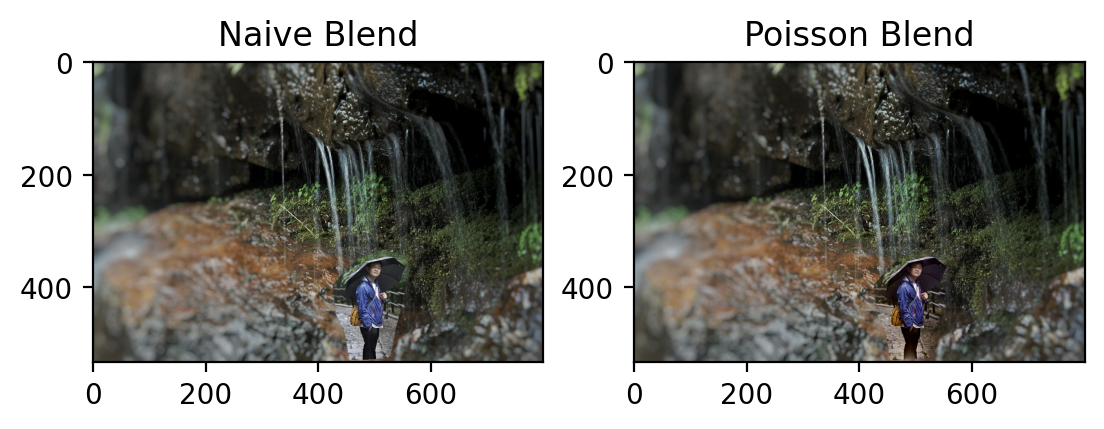

In [15]:

# after alignment (masking_code.py)
ratio = 1
fg_name = "father"
bg_name = "rain_rock"
fg = cv2.resize(imageio.imread(f"data/{fg_name}_newsource.png"), (0, 0), fx=ratio, fy=ratio)
bg = cv2.resize(imageio.imread(f"data/{bg_name}.jpg"), (0, 0), fx=ratio, fy=ratio)
mask = cv2.resize(imageio.imread(f"data/{bg_name}_mask.png"), (0, 0), fx=ratio, fy=ratio)

fg = fg / 255.
bg = bg / 255.
mask = (mask.sum(axis=2, keepdims=True) > 0)


blend_img = poisson_blend(fg, mask, bg)

plt.subplot(121)
plt.imshow(fg * mask + bg * (1 - mask))
plt.title('Naive Blend')
plt.subplot(122)
plt.imshow(blend_img)
plt.title('Poisson Blend')
plt.show()